In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta base del proyecto P07
BASE_DIR = Path("/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p07_alma_pipeline")
DATA_FILE = BASE_DIR / "data" / "alma_sample.csv"
IMG_DIR = BASE_DIR / "img"

IMG_DIR.mkdir(exist_ok=True)

df = pd.read_csv(DATA_FILE)

df.head()


,project_code,ra,dec,frequency,resolution,instrument
0,2019.1.00001.S,150.25,-35.20,230.5,0.7,ALMA-12m
1,2021.1.00423.S,10.33,-72.11,345.0,0.4,ALMA-7m


In [2]:
print("Shape:", df.shape)
print("\nColumnas:\n", df.columns.tolist())

print("\nInfo:")
display(df.info())

print("\nDescripción numérica:")
display(df.describe())

print("\nInstrumentos únicos:")
print(df["instrument"].unique())


Shape: (2, 6)

Columnas:
 ['project_code', 'ra', 'dec', 'frequency', 'resolution', 'instrument']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   project_code  2 non-null      object 
 1   ra            2 non-null      float64
 2   dec           2 non-null      float64
 3   frequency     2 non-null      float64
 4   resolution    2 non-null      float64
 5   instrument    2 non-null      object 
dtypes: float64(4), object(2)
memory usage: 228.0+ bytes


None


Descripción numérica:


,ra,dec,frequency,resolution
count,2.000000,2.000000,2.000000,2.000000
mean,80.290000,-53.655000,287.750000,0.550000
std,98.938381,26.099311,80.963726,0.212132
min,10.330000,-72.110000,230.500000,0.400000
25%,45.310000,-62.882500,259.125000,0.475000
50%,80.290000,-53.655000,287.750000,0.550000
75%,115.270000,-44.427500,316.375000,0.625000
max,150.250000,-35.200000,345.000000,0.700000



Instrumentos únicos:
['ALMA-12m' 'ALMA-7m']


In [3]:
import numpy as np

df2 = df.copy()

# Normalizamos defensivamente por si en el futuro el CSV real tiene valores raros
freq = df2["frequency"].astype(float)
res = df2["resolution"].astype(float)

# 1) Normalización min-max de frecuencia
freq_min, freq_max = freq.min(), freq.max()
if freq_max > freq_min:
    freq_score = (freq - freq_min) / (freq_max - freq_min)
else:
    freq_score = pd.Series(0.5, index=df2.index)

# 2) Resolución: menor es mejor → invertimos
res_min, res_max = res.min(), res.max()
if res_max > res_min:
    res_score = 1 - (res - res_min) / (res_max - res_min)
else:
    res_score = pd.Series(0.5, index=df2.index)

res_score = res_score.clip(0, 1)

# 3) Peso por tipo de instrumento (ejemplo simple)
instrument_weights = {
    "ALMA-12m": 1.0,
    "ALMA-7m": 0.9
}
inst_score = df2["instrument"].map(instrument_weights).fillna(0.8)

# Score final (ponderado)
df2["interest_score"] = (
    0.4 * freq_score +
    0.4 * res_score +
    0.2 * inst_score
)

# Normalizamos a 0–100
df2["interest_score"] = (df2["interest_score"] - df2["interest_score"].min()) / (
    df2["interest_score"].max() - df2["interest_score"].min() if df2["interest_score"].max() > df2["interest_score"].min() else 1
)
df2["interest_score"] = (df2["interest_score"] * 100).round(1)

top10 = df2.sort_values("interest_score", ascending=False).head(10)

print("Top 10 observaciones ALMA por 'interest_score':")
top10[["project_code", "ra", "dec", "frequency", "resolution", "instrument", "interest_score"]]


Top 10 observaciones ALMA por 'interest_score':


,project_code,ra,dec,frequency,resolution,instrument,interest_score
1,2021.1.00423.S,10.33,-72.11,345.0,0.4,ALMA-7m,100.0
0,2019.1.00001.S,150.25,-35.20,230.5,0.7,ALMA-12m,0.0


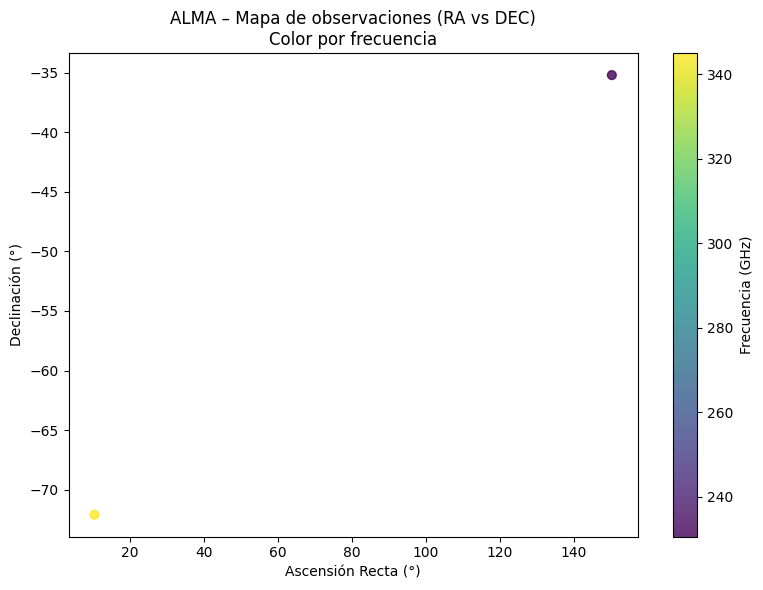

Gráfico guardado en: /Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p07_alma_pipeline/img/alma_ra_dec_map.png


In [4]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(
    df2["ra"],
    df2["dec"],
    c=df2["frequency"],
    s=40,
    alpha=0.8
)

plt.colorbar(sc, label="Frecuencia (GHz)")
plt.xlabel("Ascensión Recta (°)")
plt.ylabel("Declinación (°)")
plt.title("ALMA – Mapa de observaciones (RA vs DEC)\nColor por frecuencia")

# Guardamos la figura
out_file = IMG_DIR / "alma_ra_dec_map.png"
plt.tight_layout()
plt.savefig(out_file, dpi=150)
plt.show()

print(f"Gráfico guardado en: {out_file}")
